In [46]:
import torch
import vtk
import matplotlib.pyplot as plt

In [47]:
vtk_file_path = "./men_re.vtk"

In [99]:
def read_vtk(vtk_file_path):
    # vtkリーダーを作成して、ファイルを読み込む
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()

    dataset = reader.GetOutput()

    # 座標情報を取得
    points = dataset.GetPoints()
    num_points = points.GetNumberOfPoints()
    coordinates = torch.zeros(num_points, 3)
    for i in range(num_points):
        coordinates[i] = torch.tensor(points.GetPoint(i))

    mesh_coordinates = coordinates[:, :2]

    # 面情報を取得
    polys = dataset.GetPolys()
    num_polys = polys.GetNumberOfCells()
    faces = torch.zeros(num_polys, 3, dtype=int)

    # 各三角形の情報を取得
    polys.InitTraversal()
    for i in range(num_polys):
        cell = vtk.vtkIdList()
        if polys.GetNextCell(cell) == 0:
            break
        faces[i] = torch.tensor([cell.GetId(0), cell.GetId(1), cell.GetId(2)])

    return mesh_coordinates, faces, num_points, num_polys

In [177]:
from torch.utils.data import Dataset
class Mesh(Dataset):
    def __init__(self):
        self.coordinate = None
        self.faces = None


In [178]:
coordinate, faces, num_points, num_polys = read_vtk(vtk_file_path)
mesh = Mesh()
mesh.coordinate = coordinate
mesh.faces = faces
print(mesh.coordinate)
print(mesh.faces)

tensor([[ 0.4800,  0.5000],
        [ 0.4600,  0.5000],
        [ 0.4400,  0.5000],
        ...,
        [ 0.4419,  0.4640],
        [-0.4817,  0.0643],
        [-0.1496,  0.4549]])
tensor([[ 161,  162,  200],
        [ 111,  112,  201],
        [ 186,  187,  202],
        ...,
        [ 378, 2707, 2590],
        [ 322,  323, 2411],
        [2411,  323, 2464]])


In [179]:
def plot_mesh(vertices, faces, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 描画するメッシュの頂点をプロット
    ax.plot(vertices[:,0], vertices[:,1], 'bo')  # 頂点を青色の点でプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'r')  # 辺を黒色の線でプロット

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        ax.plot([v0[0], v1[0], v2[0], v0[0]], [v0[1], v1[1], v2[1], v0[1]], 'r')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.5)
    ax.axvline(0, color="black", linewidth=0.5)

    plt.show()

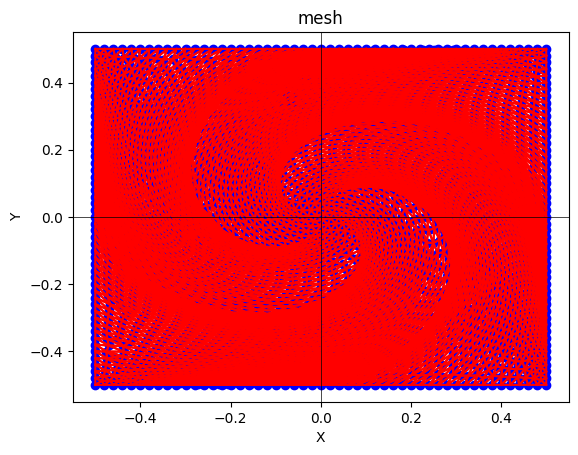

In [180]:
plot_mesh(mesh.coordinate, mesh.faces, "mesh")

# ポリゴン単位でデータを格納する

In [181]:
reader = vtk.vtkDataSetReader()
reader.SetFileName(vtk_file_path)
reader.Update()

dataset = reader.GetOutput()

# 座標情報を取得
points = dataset.GetPoints()
num_points = points.GetNumberOfPoints()
coordinates = torch.zeros(num_points, 3)
for i in range(num_points):
    coordinates[i] = torch.tensor(points.GetPoint(i))

mesh_coordinates = coordinates[:, :2]

# 面情報を取得
polys = dataset.GetPolys()
num_polys = polys.GetNumberOfCells()
faces = torch.zeros(num_polys, 3, dtype=int)

# 各三角形の情報を取得
polys.InitTraversal()
for i in range(num_polys):
    cell = vtk.vtkIdList()
    if polys.GetNextCell(cell) == 0:
        break
    faces[i] = torch.tensor([cell.GetId(0), cell.GetId(1), cell.GetId(2)])

In [183]:
# 各セルの各辺の隣接セル数を調べる
edge_neighbors = {}
num_cells = dataset.GetNumberOfCells()
for cell_index in range(num_cells):
    cell = dataset.GetCell(cell_index)
    num_edges = cell.GetNumberOfEdges()

    for edge_index in range(num_edges):
        edge = cell.GetEdge(edge_index)
        edge_points = edge.GetPointIds()

        # 辺を構成する点のインデックスを取得
        point1_id = edge_points.GetId(0)
        point2_id = edge_points.GetId(1)

        # 辺を構成する点のインデックスを照準にソート
        edge_key = (min(point1_id, point2_id), max(point1_id, point2_id))

        # 辺の隣接セル数をカウント
        if edge_key in edge_neighbors:
            edge_neighbors[edge_key] += 1
        else:
            edge_neighbors[edge_key] = 1 

boundary_edges = []

# 境界上の辺を特定
for edge_key, num_neighbors in edge_neighbors.items():
    if num_neighbors == 1:
        boundary_edges.append(edge_key)

# 境界上の辺を構成する頂点の番号を取得
boundary_points = set()     # 集合を表すデータ型、順番を持たず、重複した要素は取り除かれる

for edge_key in boundary_edges:
    boundary_points.add(edge_key[0])
    boundary_points.add(edge_key[1])

# print("境界上の頂点の番号：", boundary_points)


# 境界でない頂点に関して、そのポリゴンの情報を格納する

In [206]:
from torch.utils.data import Dataset
class Polygon(Dataset):
    def __init__(self, num_node, num_face):
        self.nodeID = torch.zeros(num_node)
        self.coordinate = torch.zeros(num_node, 2)
        self.faces = torch.zeros(num_face, 3)


    
poly_count = 0
for pointId in range(num_points):       # pointId:自由点の頂点番号
    if pointId in boundary_points:
        continue
    else:
        poly_count += 1
        print("pointId:", pointId)
    mask = (faces == pointId)
    if mask.any():
        count = torch.sum(mask).item()
    num_node = count + 1
    num_face = count
    polygon_number = poly_count - 1 



    
    polygon_i = f"polygon_{polygon_number}"
    # print(polygon_i)
    polygon_i = Polygon(num_node, num_face)
    
    element_to_check = pointId
    polygon_i.face = faces[(faces == element_to_check).any(dim=1)]
    print(polygon_i.face)

    polygon_i.nodeId = set()
    for i in range(len(polygon_i.face)):
        polygon_i.nodeId.add(polygon_i.face[i, 0].item())
        polygon_i.nodeId.add(polygon_i.face[i, 1].item())
        polygon_i.nodeId.add(polygon_i.face[i, 2].item())
    sorted_nodeId = sorted(polygon_i.nodeId)
    polygon_i.nodeID = torch.tensor(list(sorted_nodeId))
    
    point_id_index = (polygon_i.nodeID == pointId).nonzero().item()

    value_to_move = polygon_i.nodeID[point_id_index]
    polygon_i.nodeID = torch.cat((value_to_move.unsqueeze(0), polygon_i.nodeID[polygon_i.nodeID != pointId]))

    # print(polygon_i.nodeID)

    for i in range(num_node):
        polygon_i.coordinate[i] = mesh_coordinates[polygon_i.nodeID[i].item()]


    indices = torch.nonzero(torch.isin(polygon_i.face, polygon_i.nodeID))
    for idx in range(indices.size(0)):
        row_idx, col_idx = indices[idx]
        value_to_replace = polygon_i.face[row_idx, col_idx]
        polygon_i.face[row_idx, col_idx] = (polygon_i.nodeID == value_to_replace).nonzero().item()
    polygon_i.faces = polygon_i.face.long()

    setattr(mesh, f"polygon_{polygon_number}", polygon_i)

    print(polygon_i.nodeID)
    print(polygon_i.coordinate)
    print(polygon_i.faces)

    


pointId: 200
tensor([[ 161,  162,  200],
        [ 161,  200,  304],
        [ 200,  162,  305],
        [2347, 2364,  200],
        [2347,  200,  305],
        [2364,  304,  200]])
tensor([ 200,  161,  162,  304,  305, 2347, 2364])
tensor([[ 0.4962, -0.2285],
        [ 0.5000, -0.2600],
        [ 0.5000, -0.2400],
        [ 0.4962, -0.2497],
        [ 0.4961, -0.2073],
        [ 0.4912, -0.1966],
        [ 0.4915, -0.2188]])
tensor([[1, 2, 0],
        [1, 0, 3],
        [0, 2, 4],
        [5, 6, 0],
        [5, 0, 4],
        [6, 3, 0]])
pointId: 201
tensor([[ 111,  112,  201],
        [ 111,  201,  352],
        [ 201,  112,  353],
        [2995,  352,  201],
        [2995,  201, 2996],
        [2996,  201,  353]])
tensor([ 201,  111,  112,  352,  353, 2995, 2996])
tensor([[-0.2261, -0.4960],
        [-0.2600, -0.5000],
        [-0.2400, -0.5000],
        [-0.2464, -0.4954],
        [-0.2063, -0.4960],
        [-0.2140, -0.4913],
        [-0.1881, -0.4897]])
tensor([[1, 2, 0],
      

tensor([[ 0.2707, -0.4755],
        [ 0.2400, -0.5000],
        [ 0.2600, -0.5000],
        [ 0.2603, -0.4672],
        [ 0.2933, -0.4683],
        [ 0.2938, -0.4451]])
tensor([ 203,  136,  137,  375,  376, 2574])
tensor([[1, 2, 0],
        [0, 2, 4],
        [1, 0, 3],
        [0, 4, 5],
        [0, 5, 3]])


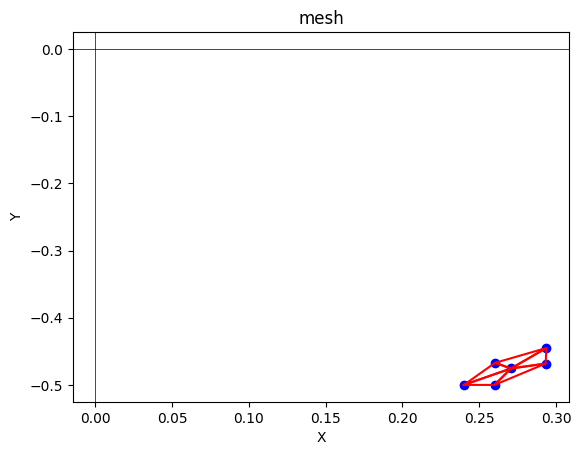

In [208]:
print(mesh.polygon_3.coordinate)
print(mesh.polygon_3.nodeID)
print(mesh.polygon_3.faces)
plot_mesh(mesh.polygon_3.coordinate, mesh.polygon_3.faces, "mesh")